In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import BoundaryNorm

import cartopy.crs as ccrs
from som import Som, cluster

In [2]:
def calc_anom(da):
    climatology_mean = da.groupby("time.month").mean("time")
    climatology_std = da.groupby("time.month").std("time")
    anom = xr.apply_ufunc(
        lambda x, m, s: (x - m) / s,
        da.groupby("time.month"),
        climatology_mean,
        climatology_std,
    )
    return anom

In [3]:
print("Self-Organizing Feature Map Analysis")
# Load data
ds = xr.open_dataset("../Data/u850.nc")
uwnd850 = ds["uwnd"].sel(
    lat=slice(60.0, -10.0),
    lon=slice(100.0, 180.0),
    time=slice("1991", "2023"),
)
uwnd850 = uwnd850.sel(time=uwnd850.time.dt.month.isin([6, 7, 8]))
uwnd850_anom = calc_anom(uwnd850)
uwnd850_anom = uwnd850_anom.drop_vars(["month", "level"])
# Coordinates
lon = uwnd850_anom.lon
lat = uwnd850_anom.lat
nd = len(lon) * len(lat)
nt = uwnd850_anom.time.size

# Reshape to (nd, nt)
x = uwnd850_anom.values.reshape(nt, nd).T

Self-Organizing Feature Map Analysis


In [4]:
# SOM parameters
m1 = 3
m2 = 3
nter = 5000
alpha0 = 5.0
alphamin = 0.05
taua = 1000
sigma0 = 2.5
taus = 500

In [5]:
# Train SOM
w = Som(x, nd, nt, m1, m2, nter, alpha0, taua, alphamin, sigma0, taus)

Training SOM...
Input data normalized
Iteration 50, alpha=4.7609, sigma=2.2666
Iteration 100, alpha=4.5287, sigma=2.0509
Iteration 150, alpha=4.3078, sigma=1.8558
Iteration 200, alpha=4.0977, sigma=1.6792
Iteration 250, alpha=3.8979, sigma=1.5194
Iteration 300, alpha=3.7078, sigma=1.3748
Iteration 350, alpha=3.5270, sigma=1.2439
Iteration 400, alpha=3.3550, sigma=1.1256
Iteration 450, alpha=3.1913, sigma=1.0185
Iteration 500, alpha=3.0357, sigma=0.9215
Iteration 550, alpha=2.8876, sigma=0.8338
Iteration 600, alpha=2.7468, sigma=0.7545
Iteration 650, alpha=2.6128, sigma=0.6827
Iteration 700, alpha=2.4854, sigma=0.6177
Iteration 750, alpha=2.3642, sigma=0.5589
Iteration 800, alpha=2.2489, sigma=0.5058
Iteration 850, alpha=2.1392, sigma=0.5000
Iteration 900, alpha=2.0349, sigma=0.5000
Iteration 950, alpha=1.9356, sigma=0.5000
Iteration 1000, alpha=1.8412, sigma=0.5000
Iteration 1050, alpha=1.7514, sigma=0.5000
Iteration 1100, alpha=1.6660, sigma=0.5000
Iteration 1150, alpha=1.5848, sigma=

In [6]:
# Cluster
cluster1, cluster2, qerr, qerror, count = cluster(x, w, nd, nt, m1, m2)

Clustering...
Neurons (i,j) counts quantization_error:
Neuron 1 (1, 1) = 399 (1.1021)
Neuron 2 (2, 1) = 386 (1.1190)
Neuron 3 (3, 1) = 329 (1.1226)
Neuron 4 (1, 2) = 280 (1.1211)
Neuron 5 (2, 2) = 299 (1.1297)
Neuron 6 (3, 2) = 267 (1.1139)
Neuron 7 (1, 3) = 362 (1.0713)
Neuron 8 (2, 3) = 373 (1.1030)
Neuron 9 (3, 3) = 341 (1.1230)
Quantization Error = 1.1108


In [7]:
# ---------------------------
# Average maps per neuron
# ---------------------------
# Pre-allocate storage for average maps (lon x lat x neurons)
avg_maps = np.empty((len(lon), len(lat), m1 * m2), dtype=float)

# Build neuron indices for each sample (1-based like Julia)
neuron_indices = cluster1 + (cluster2 - 1) * m1  # shape (nt,)

for neuron in range(1, m1 * m2 + 1):
    inds = np.where(neuron_indices == neuron)[0]
    if inds.size == 0:
        avg_maps[:, :, neuron - 1] = np.nan
    else:
        # mean over selected time indices
        sel = uwnd850_anom.isel(time=inds).mean(dim="time", keep_attrs=False)
        sel = sel.transpose("lon", "lat")
        avg_maps[:, :, neuron - 1] = sel.values

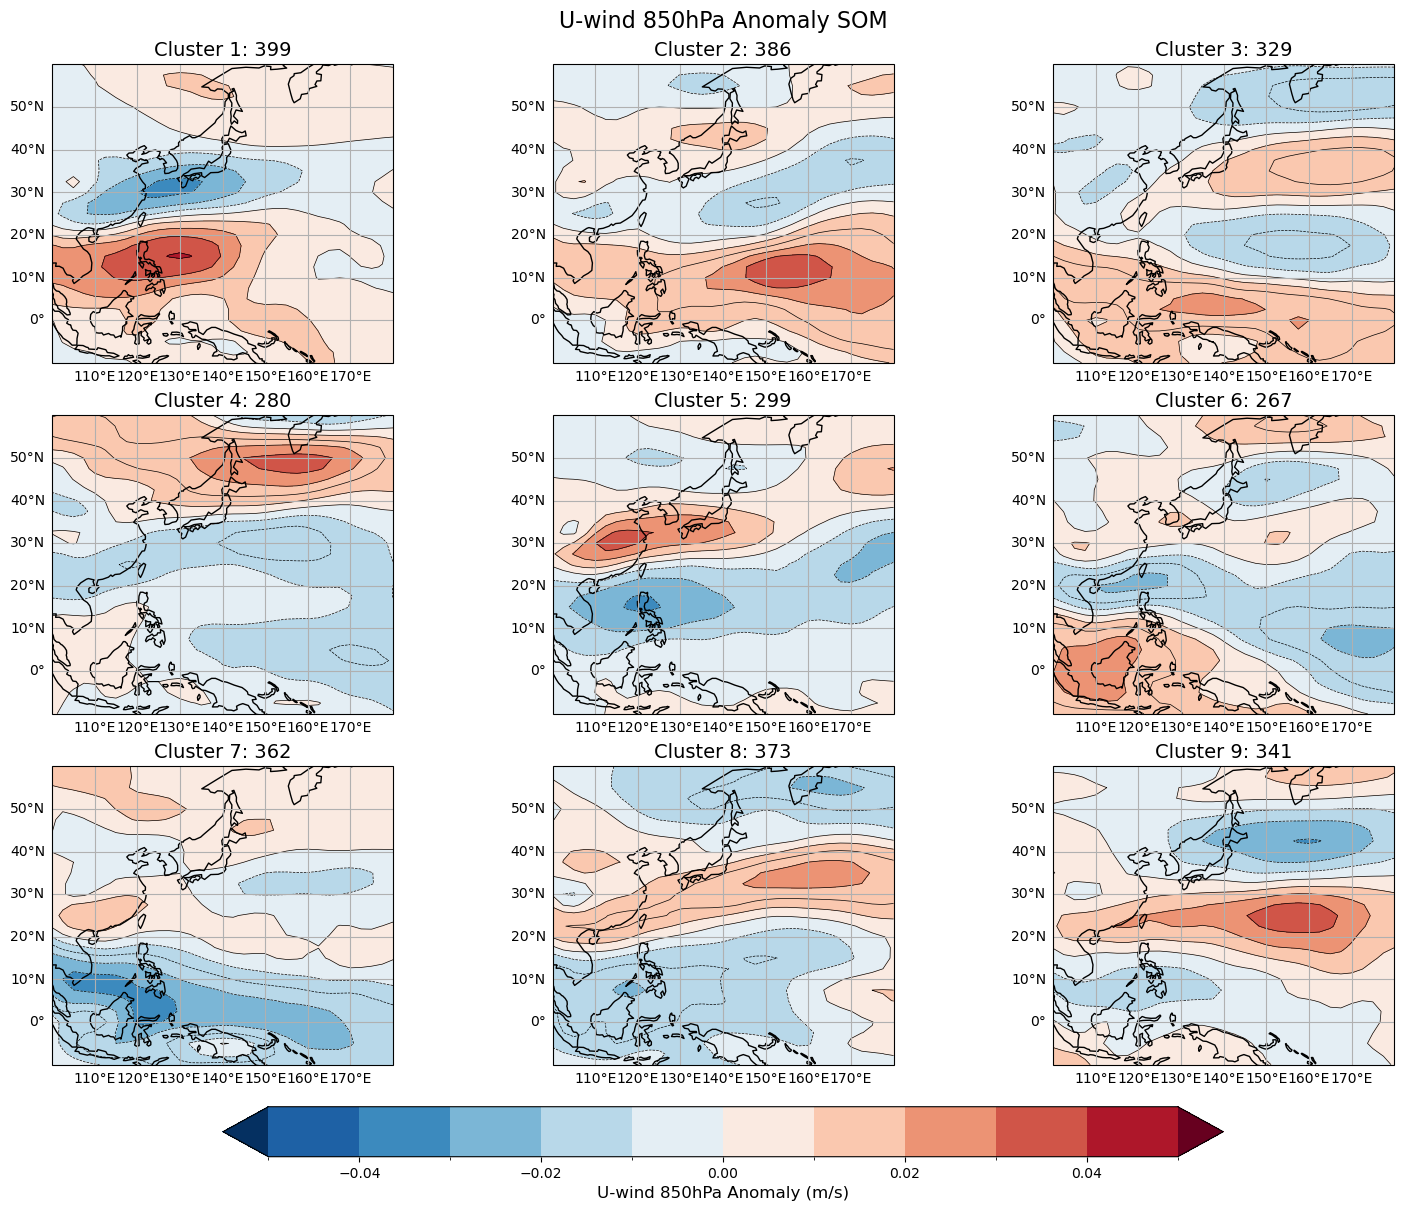

In [8]:
vmin = -0.05
vmax = 0.05
boundaries = np.linspace(-0.05, 0.05, 11)
norm = BoundaryNorm(boundaries=boundaries, ncolors=256, extend="both")

fig = plt.figure(layout="constrained", figsize=(m1 * 5, m2 * 4))
axes = fig.subplots(3, 3, subplot_kw={"projection": ccrs.PlateCarree()})
for i, ax in enumerate(axes.flat):
    feature = avg_maps[:, :, i]
    im = ax.contourf(
        uwnd850_anom.lon,
        uwnd850_anom.lat,
        feature.T,
        cmap="RdBu_r",
        norm=norm,
        transform=ccrs.PlateCarree(),
    )
    ax.contour(im, colors="black", linewidths=(0.5,))
    ax.set_title(f"Cluster {i + 1}: {count[i]}", fontsize=14)
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    ax.set_extent([100, 180, -10, 60], crs=ccrs.PlateCarree())

cbar = fig.colorbar(
    ScalarMappable(norm=norm, cmap="RdBu_r"),
    ax=axes[:, :],
    location="bottom",
    fraction=0.05,
    pad=0.02,
)
cbar.set_label("U-wind 850hPa Anomaly (m/s)", fontsize=12)
plt.suptitle("U-wind 850hPa Anomaly SOM", fontsize=16)
plt.savefig("../Results/uwnd850_anom_som.png", dpi=300)

In [9]:
# Counting
clusters = cluster1 + (cluster2 - 1) * 3

In [10]:
time = uwnd850_anom.time

In [11]:
df = pd.DataFrame(
    {"cluster": clusters},
    index=pd.to_datetime(time),
)

In [12]:
df["cluster"] = df["cluster"].astype("category")

# Extract year
df["year"] = df.index.to_period(freq="Y")

# Group and count
counts = df.groupby(["cluster", "year"], observed=True).size().reset_index(name="count")
counts = counts.pivot(index="year", columns="cluster", values="count").fillna(0)

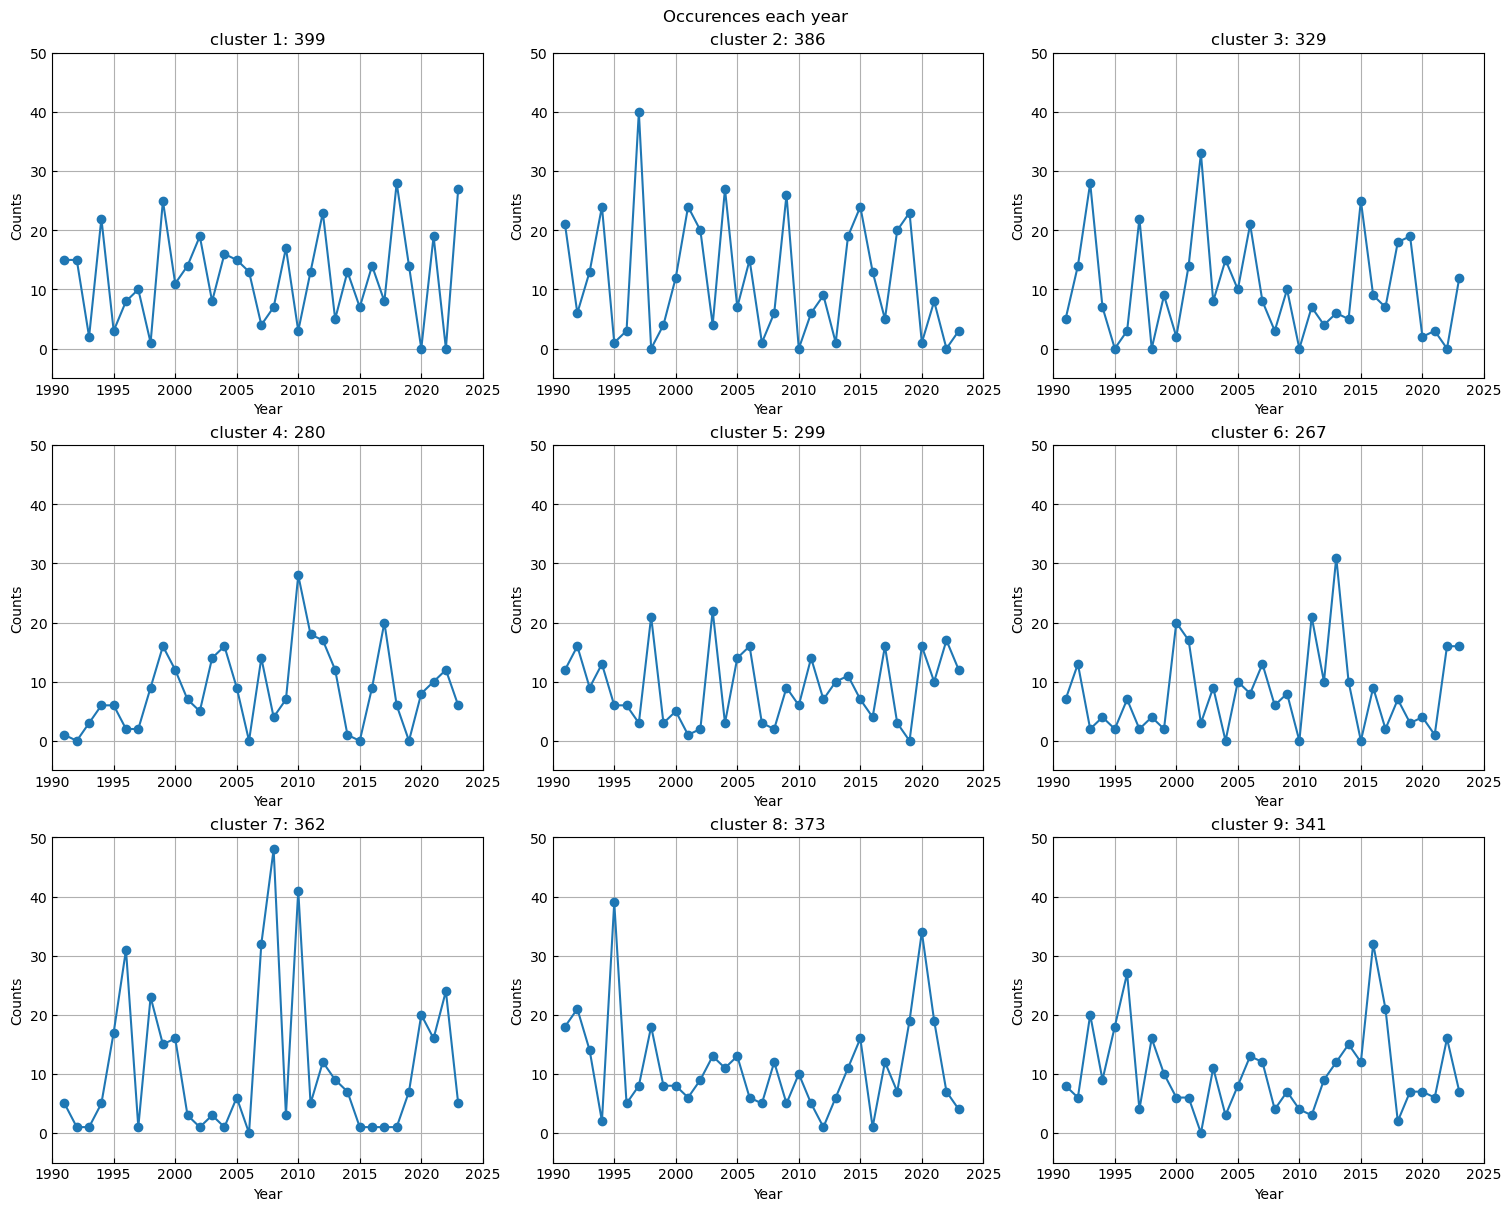

In [13]:
# Plot time series
# Create one figure with 3x3 subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 12), layout="constrained")
axes = axes.flatten()  # flatten to easily iterate over
t = range(1991, 2024)
for i in range(0, 9):
    ax = axes[i]
    ax.plot(t, counts[i + 1], "-o")
    ax.set_xlabel("Year")
    ax.set_ylabel("Counts")
    ax.set_ylim(-5, 50)
    ax.set_xlim(1990, 2025)
    ax.tick_params(axis="both", tickdir="in")
    ax.grid(True)
    ax.set_title(f"cluster {i + 1}: {int(counts[i + 1].sum())}")

fig.suptitle("Occurences each year")
# Save one combined figure
plt.savefig("../Results/u850a_cluster_timeseries.png")

In [16]:
# ---------------------------
# Composite for OLR_JJA
# ---------------------------
olr_anom = xr.open_dataset("../Data/olr_anom2.nc")
olr_jja = olr_anom["olr"].sel(time=olr_anom.time.dt.month.isin([6, 7, 8]))

In [17]:
# Ensure data is filtered to JJA and aligned with SOM samples
da_comp = olr_jja
if 'month' in da_comp.coords:
    da_comp = da_comp.drop_vars('month')
# The SOM training was done on JJA data. Ensure this data matches in length.
da_comp_jja = da_comp.sel(time=da_comp.time.dt.month.isin([6, 7, 8]))

# Building neuron labels (1-based) from SOM output
# m1, cluster1, cluster2 come from the SOM training section
neuron_labels = cluster1 + (cluster2 - 1) * m1

# Calculate average maps per neuron
# We use the dimensions of the composite data
avg_maps_comp = np.empty((len(da_comp_jja.lon), len(da_comp_jja.lat), m1 * m2), dtype=float)

for neuron in range(1, m1 * m2 + 1):
    inds = np.where(neuron_labels == neuron)[0]
    if inds.size == 0:
        avg_maps_comp[:, :, neuron - 1] = np.nan
    else:
        # Mean over selected time indices
        sel_mean = da_comp_jja.isel(time=inds).mean(dim="time", keep_attrs=False)
        # Transpose to (lon, lat) to match the plotting expectation in some cells
        if 'lon' in sel_mean.dims and 'lat' in sel_mean.dims:
            sel_mean = sel_mean.transpose("lon", "lat")
        avg_maps_comp[:, :, neuron - 1] = sel_mean.values

# Replace the original avg_maps (or whatever the plotting block uses)
avg_maps = avg_maps_comp

NameError: name 'p_values_maps' is not defined

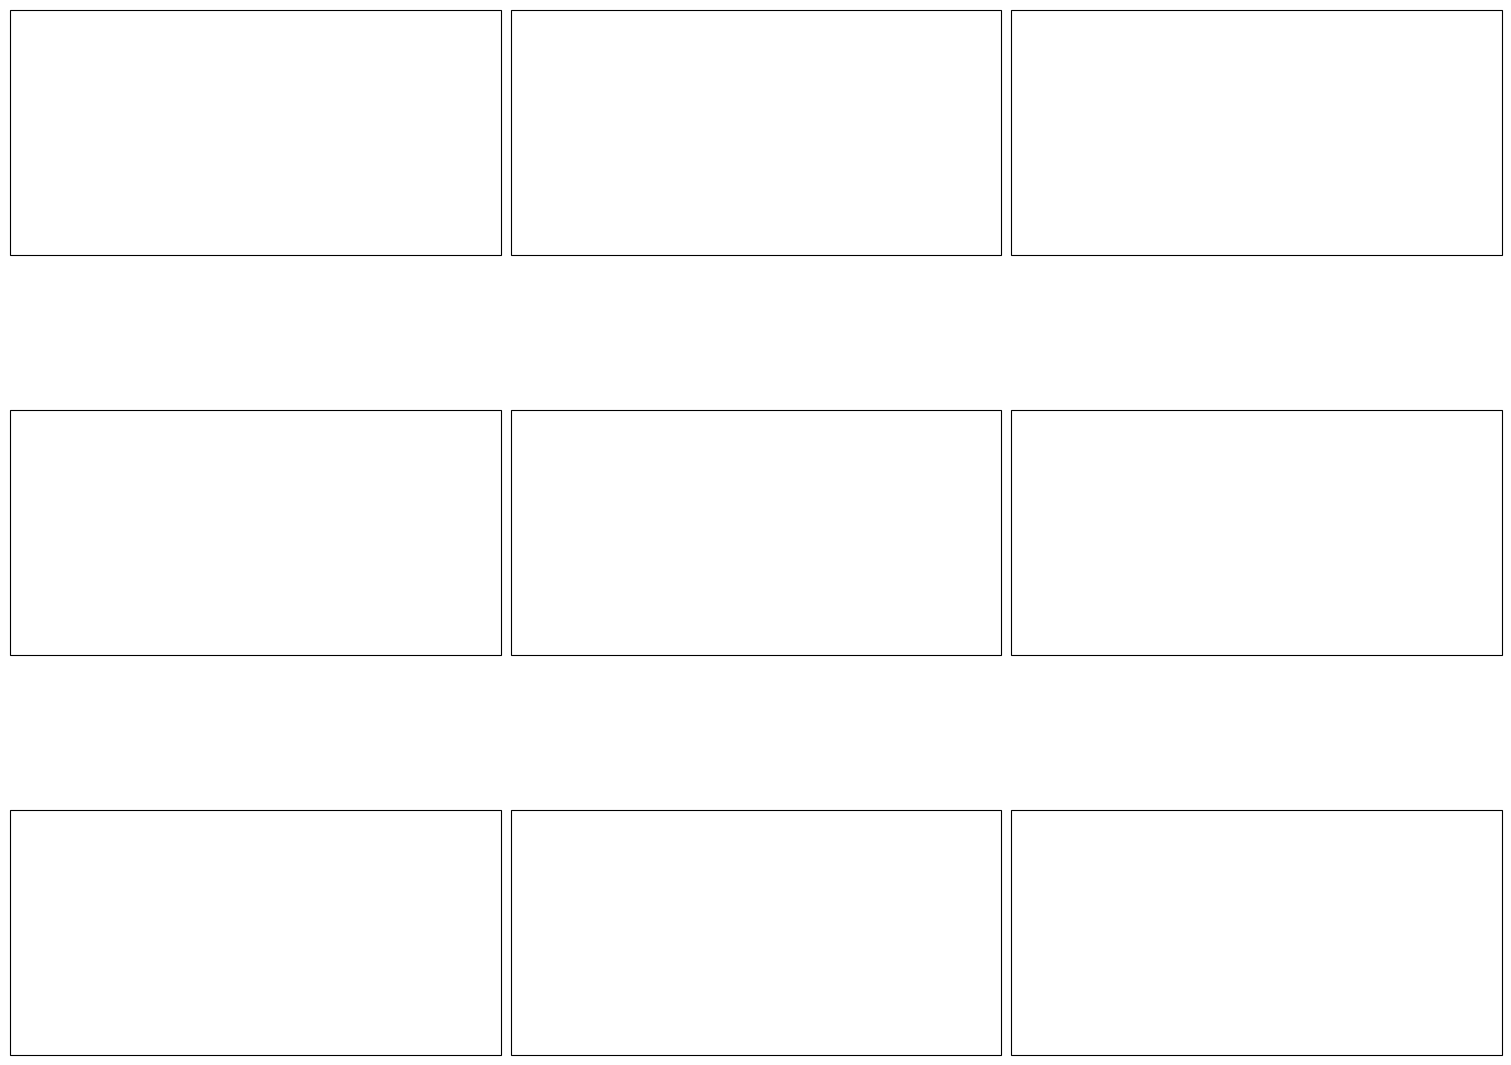

In [18]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.cm import ScalarMappable
from matplotlib.colors import BoundaryNorm

# ---------------------------
# Visualization with Stippling
# ---------------------------

# Plot parameters
vmin = -0.5 # Adjust based on your data range
vmax = 0.5
boundaries = np.linspace(vmin, vmax, 21)
norm = BoundaryNorm(boundaries=boundaries, ncolors=256, extend="both")

# Significance Level (e.g., 95%)
sig_level = 0.05 

fig = plt.figure(layout="constrained", figsize=(m1 * 5, m2 * 4))
axes = fig.subplots(
    m2, m1, subplot_kw={"projection": ccrs.PlateCarree(central_longitude=180)}
)

for i, ax in enumerate(axes.flat):
    # Data for this cluster
    feature = avg_maps[:, :, i]
    pval = p_values_maps[:, :, i]
    
    # 1. Plot the color shading (Mean Anomaly)
    im = ax.contourf(
        da_comp_jja.lon,
        da_comp_jja.lat,
        feature.T, # Transpose if necessary based on your array shape
        cmap="RdBu_r",
        norm=norm,
        transform=ccrs.PlateCarree(),
    )
    
    # 2. Add Contours for clarity
    # ax.contour(im, colors="k", linewidths=(0.5,), transform=ccrs.PlateCarree())
    
    # 3. Add Stippling for Significance
    # We mask values where p-value > 0.05 (insignificant) so they are NOT hatched
    # or we plot specific levels.
    
    # Method: Contourf with hatches
    # levels: [0, sig_level, 1] -> 
    # Bin 1: 0 to 0.05 (Significant) -> Apply Hatch
    # Bin 2: 0.05 to 1 (Not Significant) -> No Hatch
    ax.contourf(
        da_comp_jja.lon,
        da_comp_jja.lat,
        pval.T,
        levels=[0, sig_level, 1],
        hatches=['...', ''], # '...' = dots, '' = nothing
        colors='none', # Make the fill transparent, only show hatches
        transform=ccrs.PlateCarree()
    )

    # Titles and formatting
    ax.set_title(f"Cluster {i + 1} (n={count[i]})", fontsize=14)
    ax.coastlines()
    
    # Extent
    ax.set_extent([0, 180, -60, 60], crs=ccrs.PlateCarree())
    
    # Gridlines
    gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False

# Colorbar
cbar = fig.colorbar(
    ScalarMappable(norm=norm, cmap="RdBu_r"),
    ax=axes[:, :],
    location="bottom",
    fraction=0.05,
    pad=0.02,
)
cbar.set_label("OLR Anomaly [Stippling: p < 0.05]", fontsize=12)
plt.suptitle("OLR Anomaly Composite (JJA)", fontsize=16)

save_path = "../Results/olr_anom_som_significant.png"
plt.savefig(save_path, dpi=144)
print(f"Figure saved to {save_path}")
plt.show()